## Runtimes Experiment - Confidence Intervals

This notebook is nearly identical to `runtimes.ipynb`, except the data it consumes was run for 100 epochs and this notebook will plot confidence intervals along with the bars.

In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 200)
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [3]:
RAW = 'raw'
RUNS = 100
REPEATS = 25

In [26]:
# expt = layer, batch size = batch size, lib = dp, gsm, torch

expts = ['rnn', 'gru', 'lstm', 'mha', 'embedding', 'conv', 'linear']
names = ['torch.nn', 'DPModel', 'GSM(DPModel)', 'GSM(Model)']
filenames = ['', 'dp', 'gsm_dp', 'gsm_']
print(names, filenames)

batch_sizes = [16, 32, 64, 128, 256, 512]

['torch.nn', 'DPModel', 'GSM(DPModel)', 'GSM(Model)'] ['', 'dp', 'gsm_dp', 'gsm_']


In [27]:
def expt_iterator():
    for expt in expts:
        for bs in batch_sizes:
            for name, filename in zip(names, filenames):
                yield expt, bs, name, filename

In [28]:
new_names = []
files = []
for expt, bs, name, filename in expt_iterator():
    pickle_name = f'./{RAW}/{filename}{expt}_bs_{bs}_runs_{RUNS}_repeats_{REPEATS}'
    
    try:
        with open(pickle_name+'.pkl', 'rb') as f:
            d = pickle.load(f)

        e = 'MultiheadAttention' if expt == 'mha' else expt.upper()
        if 'nn' in name: name = f'nn.{e}'
        elif 'GSM' in name: name = f'GSM(DP{e})'
        else: name = f'DP{e}'
        new_names.append(name)
        files.append((filename, name, expt, bs, d))
    except:
        print('Failed')    
    
len(files)

Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed
Failed


108

In [29]:
df_list = []

for *row, d in files:
    if d:
        mem = [m-b for b,m in d['memory']]
        for timing, memory in zip(d['runtime'], mem):
            df_list.append(pd.Series(row + [timing, memory]))
    else:
        df_list.append(pd.Series(row + [0, 0,]))

df = pd.concat(df_list, axis=1).transpose()
df.columns = ['Filename', 'Library', 'Experiment', 'Batch Size', 'Runtime', 'Memory']
df['Runtime'] = df['Runtime'].astype(float)
df['Memory'] = df['Memory'].astype(float)

# should be 7200 (6 x 3 x 4 x 100)
df

,Filename,Library,Experiment,Batch Size,Runtime,Memory
0,,nn.RNN,rnn,16,3.341997,0.006268
1,,nn.RNN,rnn,16,3.289656,0.006268
2,,nn.RNN,rnn,16,3.277389,0.006268
3,,nn.RNN,rnn,16,3.287369,0.006268
4,,nn.RNN,rnn,16,3.260690,0.006268
...,...,...,...,...,...,...
10795,gsm_,GSM(DPLINEAR),linear,512,2.053139,1.083186
10796,gsm_,GSM(DPLINEAR),linear,512,2.054045,1.083186
10797,gsm_,GSM(DPLINEAR),linear,512,2.051572,1.083186
10798,gsm_,GSM(DPLINEAR),linear,512,2.051888,1.083186


In [30]:
df['Order'] = -1
for i,name in enumerate(new_names):
    df.loc[df['Library'] == name, 'Order'] = i
assert not (df['Order'] == -1).sum()
df = df.sort_values(by=['Order', 'Batch Size'])
df

,Filename,Library,Experiment,Batch Size,Runtime,Memory,Order
0,,nn.RNN,rnn,16,3.341997,0.006268,15
1,,nn.RNN,rnn,16,3.289656,0.006268,15
2,,nn.RNN,rnn,16,3.277389,0.006268,15
3,,nn.RNN,rnn,16,3.287369,0.006268,15
4,,nn.RNN,rnn,16,3.260690,0.006268,15
...,...,...,...,...,...,...,...
10795,gsm_,GSM(DPLINEAR),linear,512,2.053139,1.083186,107
10796,gsm_,GSM(DPLINEAR),linear,512,2.054045,1.083186,107
10797,gsm_,GSM(DPLINEAR),linear,512,2.051572,1.083186,107
10798,gsm_,GSM(DPLINEAR),linear,512,2.051888,1.083186,107


In [57]:
PALETTE = sns.color_palette(palette='Blues', n_colors=6, desat=None, as_cmap=False)[1:]
reds = sns.color_palette(palette='Reds', n_colors=6, desat=0.35, as_cmap=False)[1:]
PALETTE[1] = reds[1]
PALETTE[0] = reds[0]

def get_runtime_plot(ax, expt, df, statistic='Runtime', ylim=None, figsize=(13, 6)): 
    df = df[['Filename', 'Library', 'Experiment','Batch Size', statistic, 'Order']].copy()
    
    means = df.groupby(['Filename', 'Library', 'Experiment', 'Batch Size', 'Order']).agg('mean').reset_index()
    means.columns = ['Filename', 'Library', 'Experiment', 'Batch Size', 'Order', statistic]
    means = means.sort_values(by=['Order', 'Batch Size'])

    std = df.groupby(['Filename', 'Library', 'Experiment', 'Batch Size', 'Order']).agg('std').reset_index()
    std.columns = ['Filename', 'Library', 'Experiment', 'Batch Size', 'Order', statistic]
    std = std.sort_values(by=['Order', 'Batch Size'])
    
    sns.set_style("whitegrid")
    ax = [ax]
    plot_df = df[df['Experiment'] == expt].copy()
    
    sns.barplot(
        x='Batch Size', 
        y=statistic, 
        hue='Library', 
        ci='sd', capsize=.07, errwidth=1.,
        data=plot_df, 
        ax=ax[0], 
        palette=PALETTE
    )
    
    WIDTH = 0.15
    
    ax_ind = 0
    tmp = means.loc[(means['Experiment'] == expt), statistic]
    std_tmp = std.loc[(std['Experiment'] == expt), statistic]
    
    for i, (rect, tim, std_tim) in enumerate(zip(ax[ax_ind].patches, tmp, std_tmp)):
        width = rect.get_width()
        rect.set_width(width-(width*WIDTH))
        
        (x, y) = rect.get_xy()
        rect.set_xy((x + width*WIDTH/2, y))
        
        height = rect.get_height()
        if tim > 100.:
            annotation = f'{int(tim)}'
        elif tim > 0.:
            annotation = f'{tim:.2g}'
        else:
            annotation = ''
        ax[ax_ind].annotate(
            annotation,
            xy=(
                rect.get_x() + rect.get_width() / 2 - 0.5*rect.get_width(), 
                min(height + std_tim, ylim)
            ),
            xytext=(
                rect.get_x() + rect.get_width() / 2 - 0.4*rect.get_width(), 
                min(height + std_tim + ylim/figsize[1]*0.07, ylim+ ylim/figsize[1]*0.07)
            ),  # 3 points vertical offset
            textcoords='data',
            va='bottom', ha='left', 
            fontsize=11, rotation=45)

    plt.title('')
    ax[0].set_xlabel('Batch Size')
    if statistic == 'Runtime':
        ax[0].set_ylabel('Runtime (ms)')
    else:
        ax[0].set_ylabel('Memory (GB)')
    if ylim:
        ax[0].set_ylim(0, ylim)
    sns.despine()
    ax[0].legend(loc='upper left')
    f.patch.set_facecolor('white')
    f.tight_layout()
    return f, ax

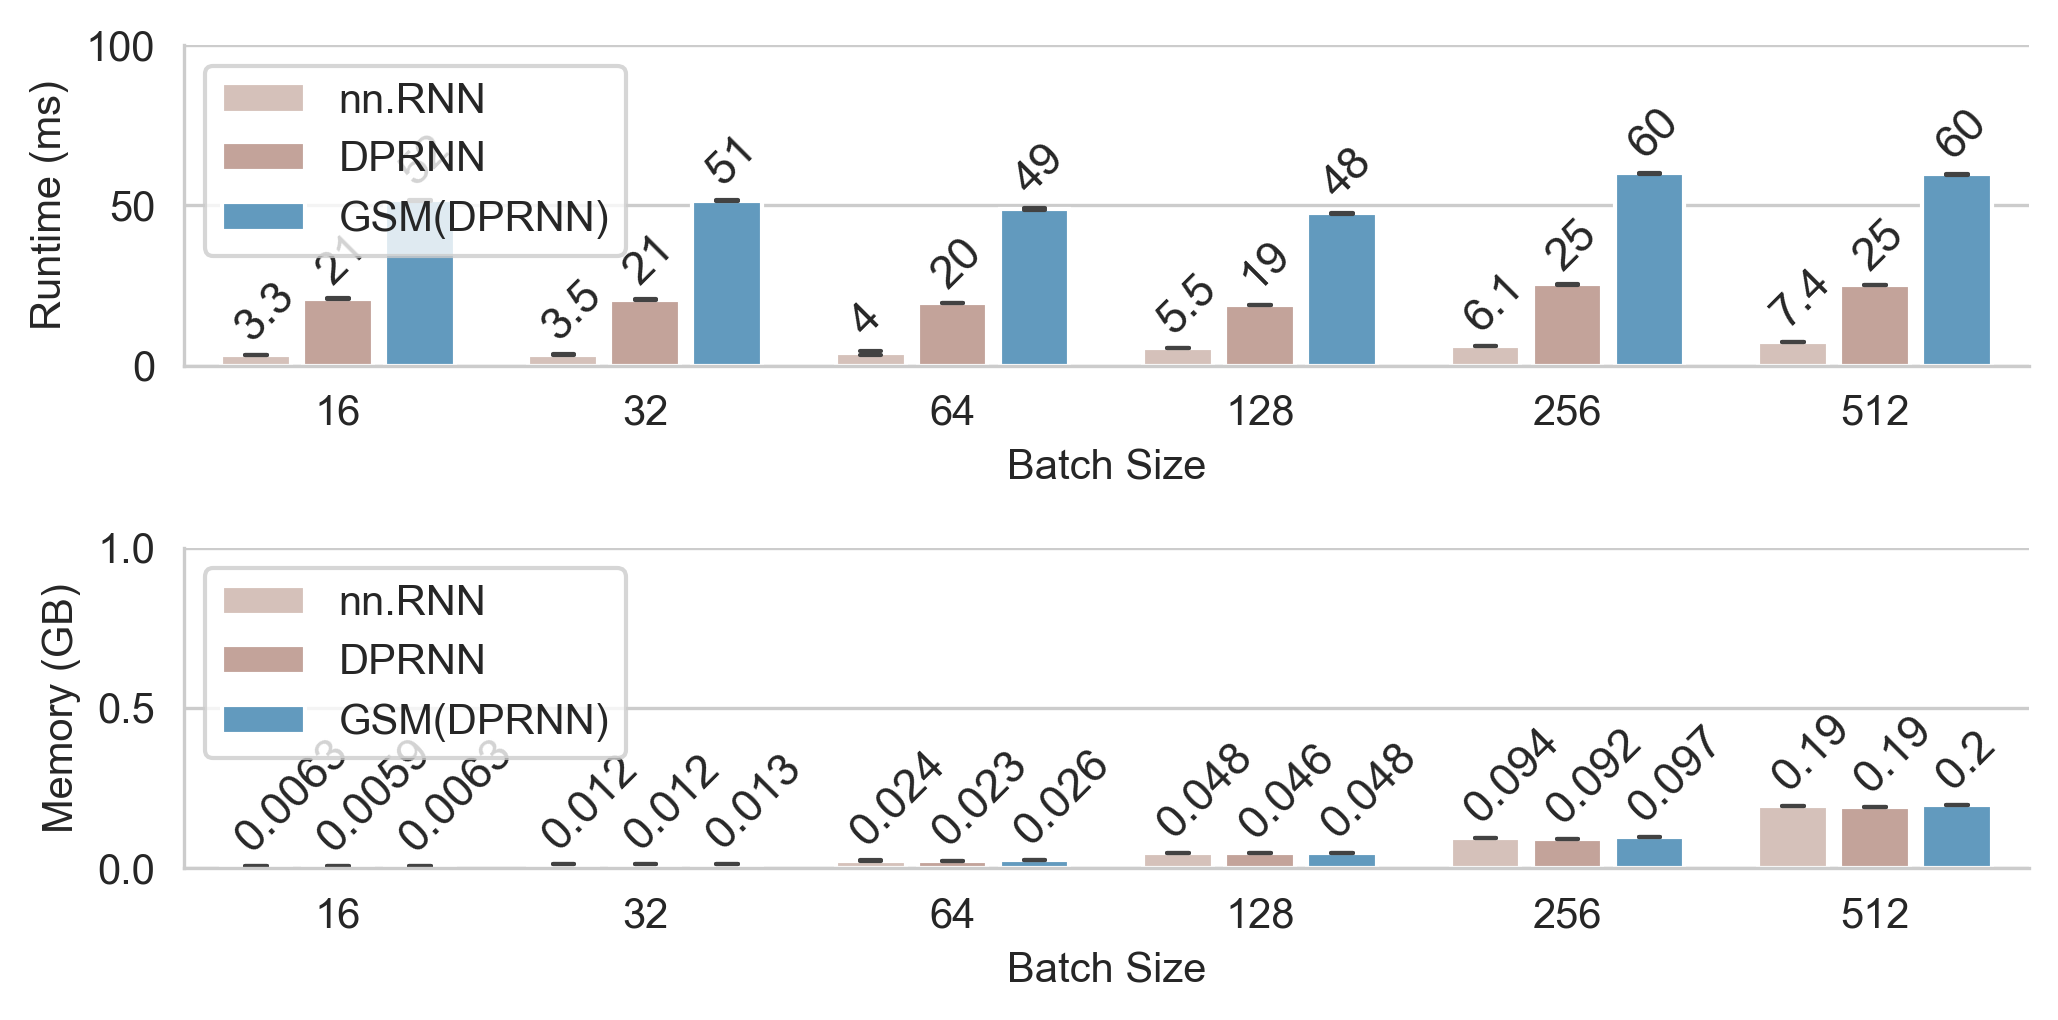

In [76]:
# def get_fig(layer, runtime_lim, memory_lim, figsize=(7, 3.5), save=True):
#     f, ax = plt.subplots(2, 1, figsize=figsize, sharey=False)
#     f, ax0 = get_runtime_plot(ax[0], layer, df, 'Runtime', runtime_lim, figsize=figsize)
#     f, ax1 = get_runtime_plot(ax[1], layer, df, 'Memory', memory_lim, figsize=figsize)
#     f.patch.set_facecolor('white')
#     f.tight_layout()
#     if save:
#         f.savefig(f'./figures/dp{layer}.pdf')
    
FIGSIZE = (7, 3.5)
f, ax = plt.subplots(2, 1, figsize=FIGSIZE, sharey=False)
f, ax0 = get_runtime_plot(ax[0], 'rnn', df, 'Runtime', 100, figsize=FIGSIZE)
f, ax1 = get_runtime_plot(ax[1], 'rnn', df, 'Memory', 1, figsize=FIGSIZE)
f.savefig('./figures/dprnn.pdf')

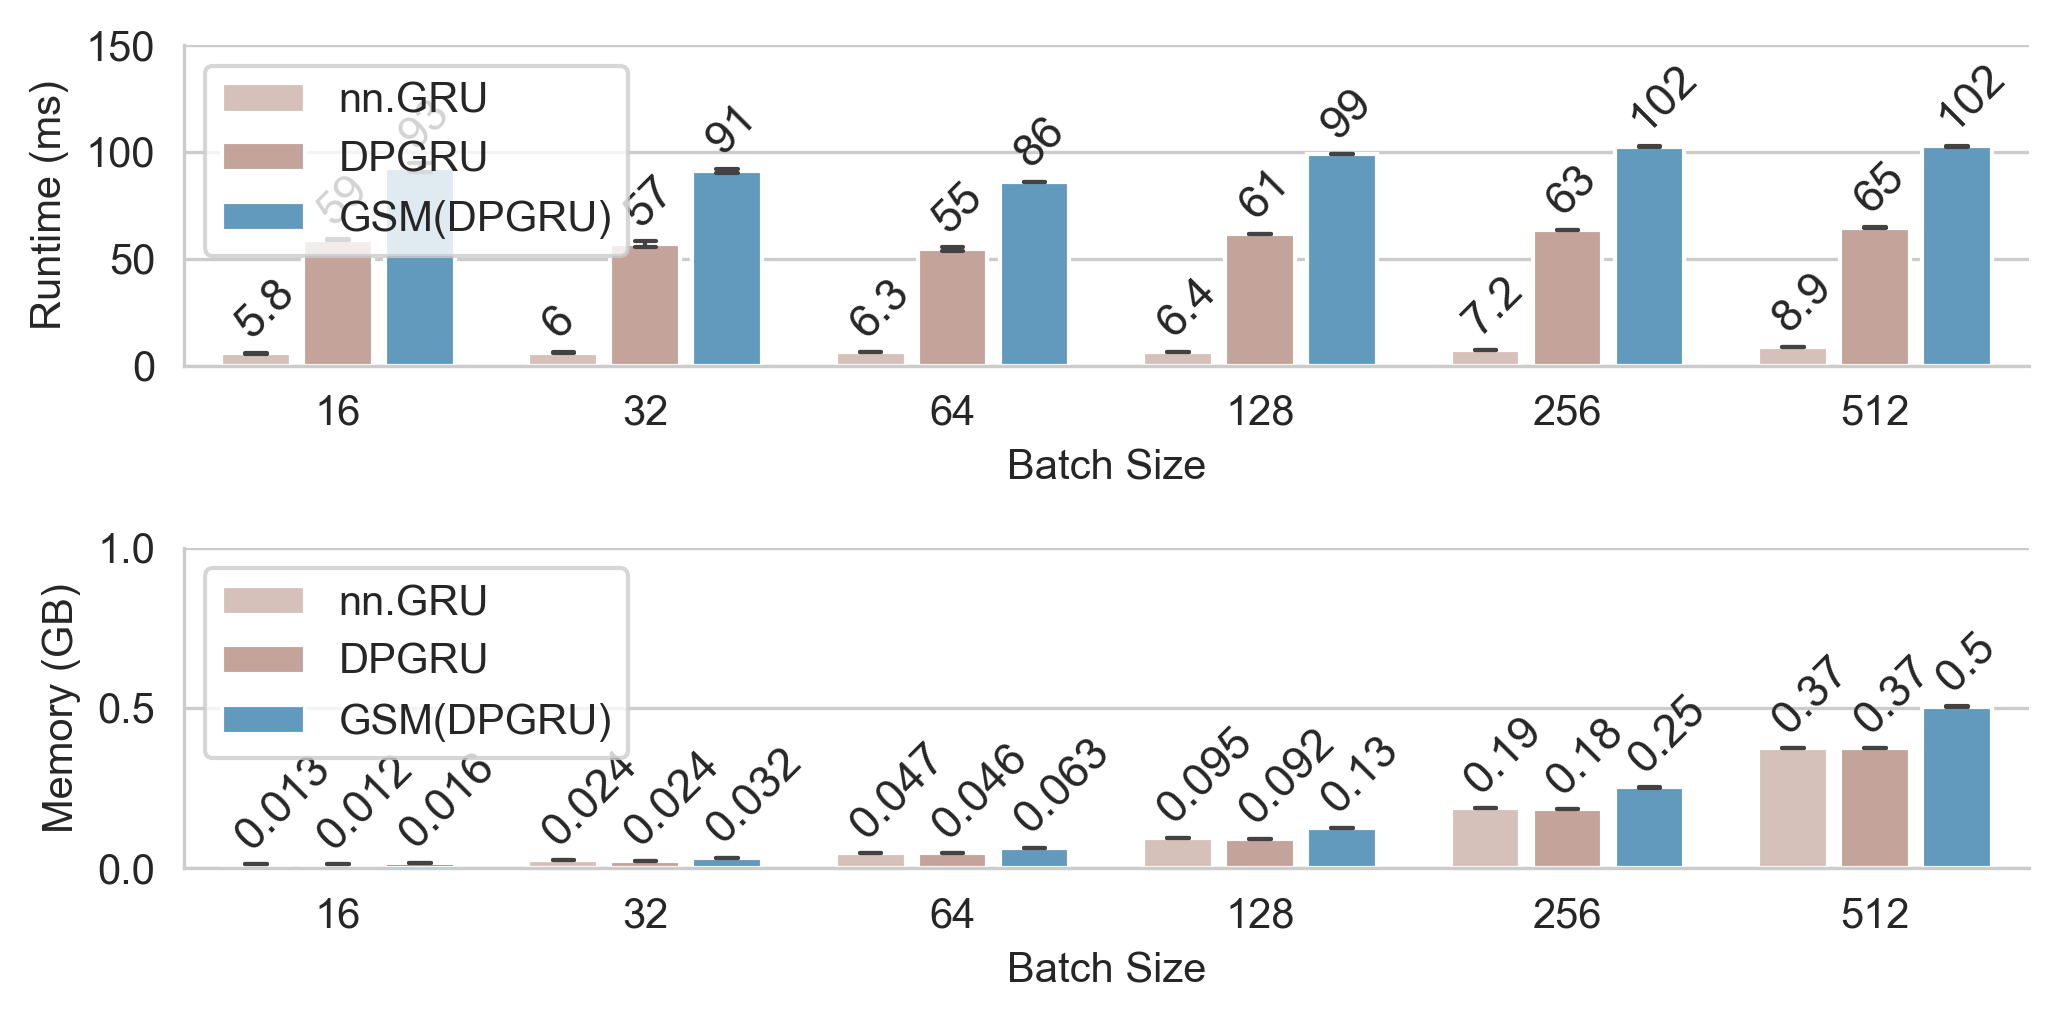

In [77]:
f, ax = plt.subplots(2, 1, figsize=FIGSIZE, sharey=False)
f, ax0 = get_runtime_plot(ax[0], 'gru', df, 'Runtime', 150, figsize=FIGSIZE)
f, ax1 = get_runtime_plot(ax[1], 'gru', df, 'Memory', 1, figsize=FIGSIZE)
f.savefig('./figures/dpgru.pdf')

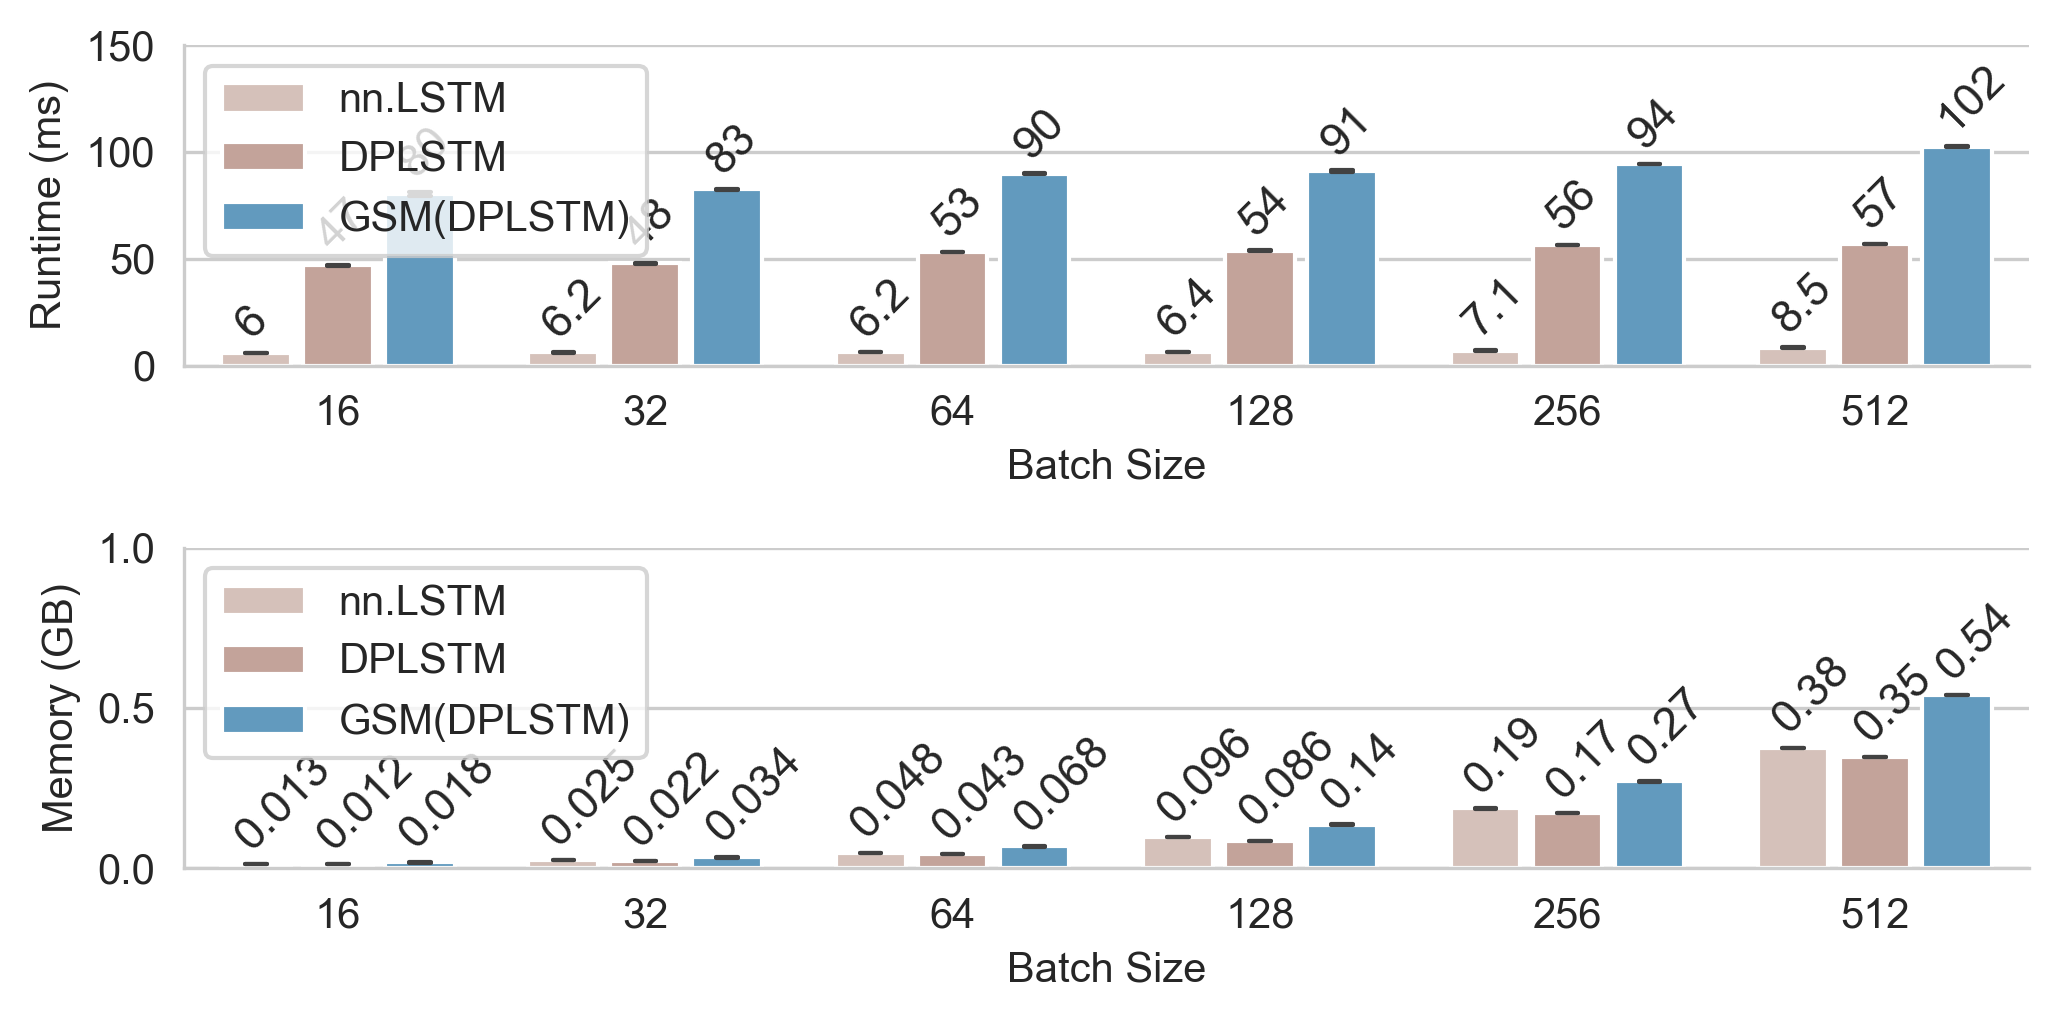

In [78]:
f, ax = plt.subplots(2, 1, figsize=FIGSIZE, sharey=False)
f, ax0 = get_runtime_plot(ax[0], 'lstm', df, 'Runtime', 150, figsize=FIGSIZE)
f, ax1 = get_runtime_plot(ax[1], 'lstm', df, 'Memory', 1, figsize=FIGSIZE)
f.savefig('./figures/dplstm.pdf')

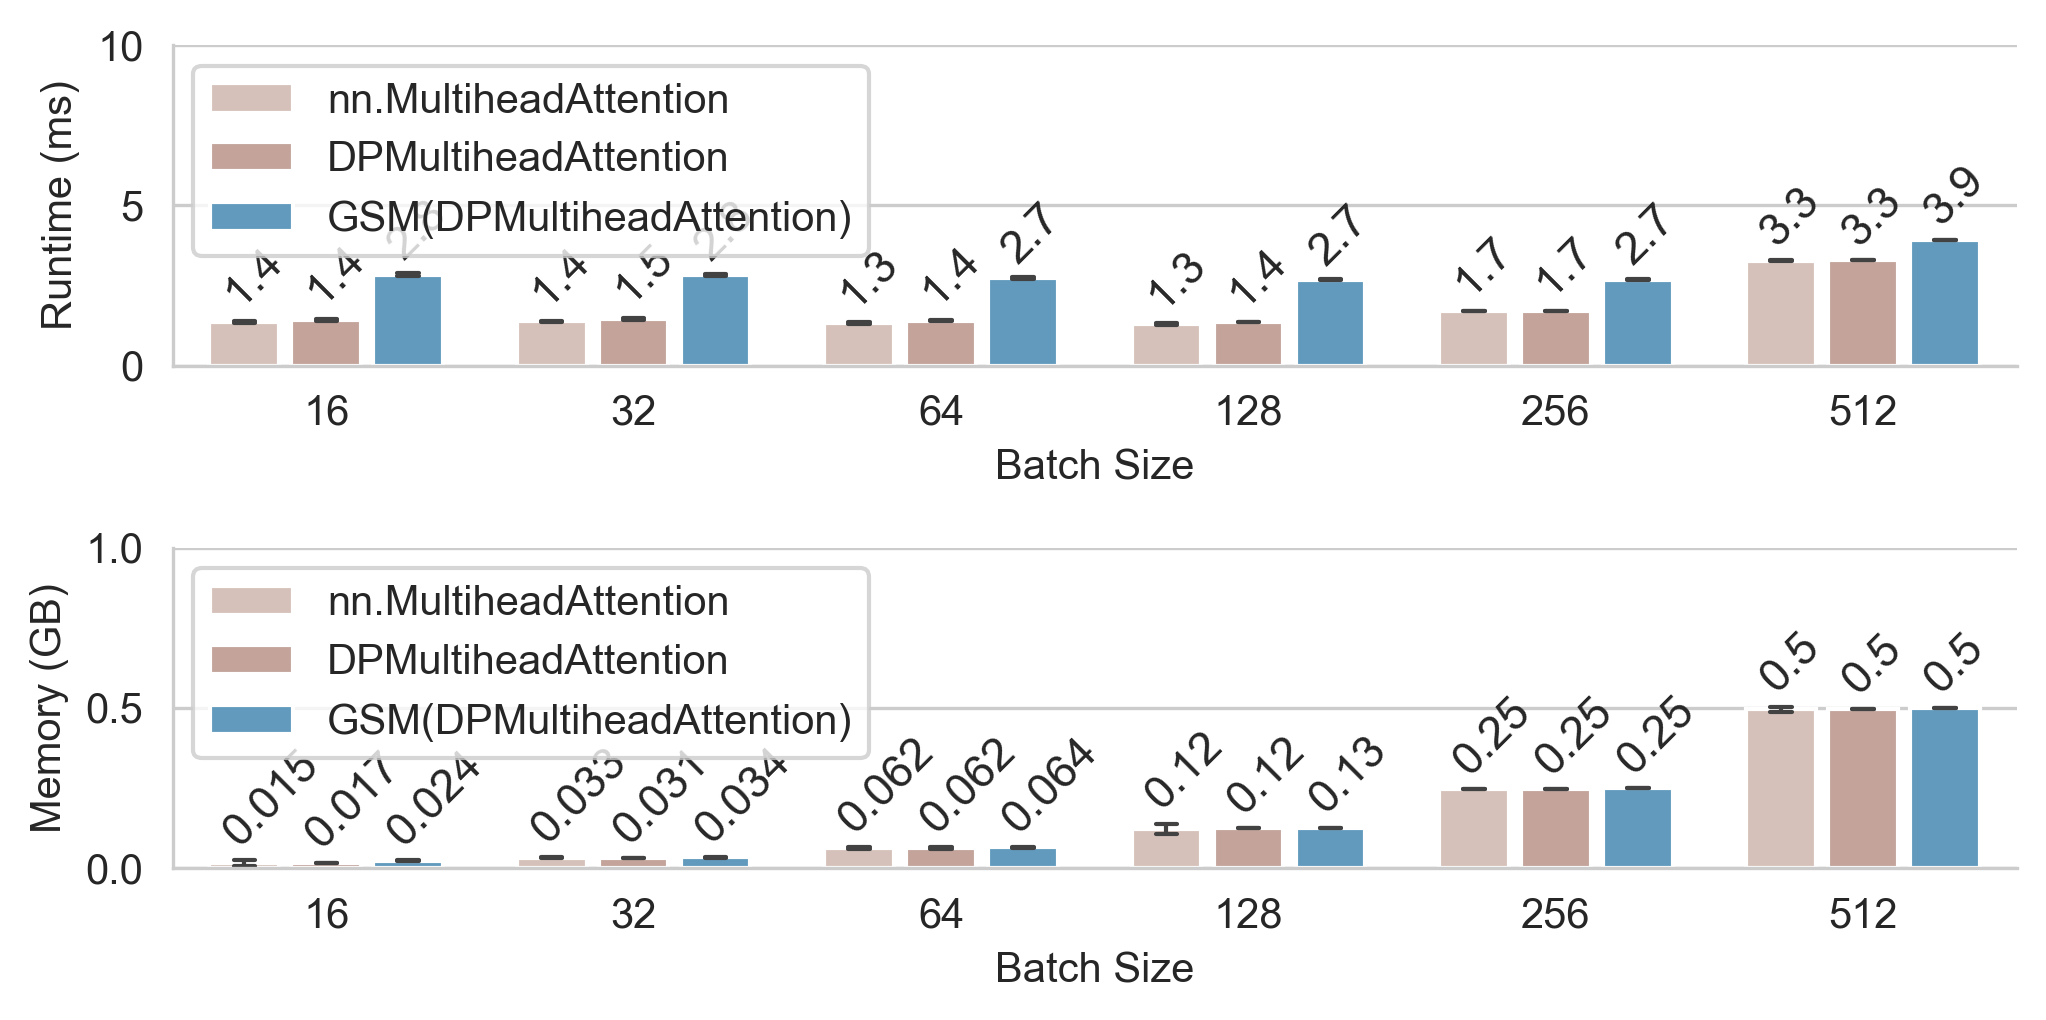

In [79]:
f, ax = plt.subplots(2, 1, figsize=FIGSIZE, sharey=False)
f, ax0 = get_runtime_plot(ax[0], 'mha', df, 'Runtime', 10, figsize=FIGSIZE)
f, ax1 = get_runtime_plot(ax[1], 'mha', df, 'Memory', 1, figsize=FIGSIZE)
f.savefig('./figures/dpmha.pdf')

In [80]:
# f, ax = plt.subplots(2, 1, figsize=FIGSIZE, sharey=False)
# f, ax0 = get_runtime_plot(ax[0], 'embedding', df, 'Runtime', 100, figsize=FIGSIZE)
# f, ax1 = get_runtime_plot(ax[1], 'embedding', df, 'Memory', 10, figsize=FIGSIZE)